# P3DX Kinematic Model

Reference:

Lecture 5 - Locomotion I [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2005%20-%20Locomotion.pdf) ]

Lecture 6 - Locomotion II [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2006%20-%20LocomotionII.pdf) ]

Lecture 7 - Locomotion III [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2007%20-%20LocomotionIII.pdf) ]

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

## Model

$$
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}_{t}
=
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}_{0}
+
\sum^{t}_{k=1}{
\begin{bmatrix}
\Delta_{s} \cos(\theta + \frac{\Delta_{\theta}}{2})  \\
\Delta_{s} \sin(\theta + \frac{\Delta_{\theta}}{2}) \\
\Delta_{\theta}
\end{bmatrix}_{k}
} \\
\Delta_{s} = \frac{R (\omega_{r} + \omega_{l})}{2} \Delta_{t} \\
\omega = \frac{R (\omega_{r} - \omega_{l})}{2L} \\
\Delta_{\theta} = \omega \Delta_{t}
$$

Where:

* $R$ is the radius of the wheels (constant);
* $L$ is the distance of the wheels to the center (constant);
* $\omega_{r}$, $\omega_{l}$ are the angular velocity of each wheel (`right` and `left` respectively, unit `rads per second`).

...

For our P3DX model, considering:

* $R = 0.195 / 2$ (meters)
* $L = 0.381 / 2$ (meters)

In [2]:
struct Robot
    R::Float64
    L::Float64
end

p3dx = Robot(0.195/2, 0.381/2)

Robot(0.0975, 0.1905)

In [3]:
struct Pose
    x::Float64
    y::Float64
    θ::Float64
end

p0 = Pose(0, 0, 0)

Pose(0.0, 0.0, 0.0)

In [4]:
function compute_odometry(robot, pose, ωr, ωl, Δt)
    R, L = robot.R, robot.L
    x, y, θ = pose.x, pose.y, pose.θ
    Δs = Δt * R * (ωr + ωl) / 2
    ω = R * (ωr - ωl) / 2L
    Δθ = Δt * ω
    
    Δx = Δs * cos(θ + Δθ / 2)
    Δy = Δs * sin(θ + Δθ / 2)
    
    return Pose(x + Δx, y + Δy, θ + Δθ)
end

compute_odometry(p3dx, p0, 2, 2, 50/1000)

Pose(0.009750000000000002, 0.0, 0.0)

**Compute Odometry for 5m straight line**

In [113]:
s = 5.0 # distance in meters
ω = 1.0 # rads per second

T = s / (ω * p3dx.R)

Δt = 50/1000 # 50 milliseconds
N = ceil(Int, T / Δt)

x0 = y0 = 0.0
θ0 = 45π / 180 # 45° in rads

poses = Vector{Pose}(undef, N+1)
poses[1] = Pose(x0, y0, θ0)

for i=1:N
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, ω, Δt)
end

N

1026

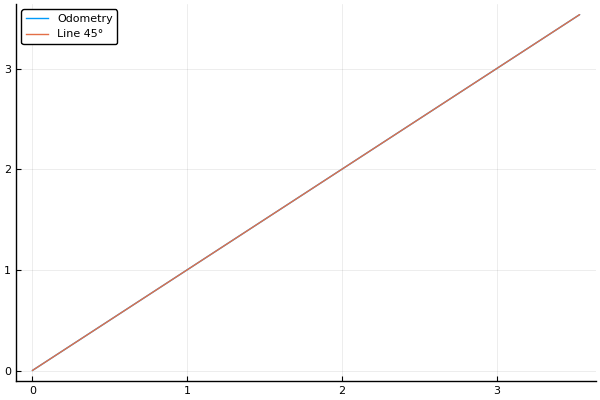

In [114]:
x = map(p -> p.x, poses)
y = map(p -> p.y, poses)
@assert x ≈ y

line45 = max(x[end], y[end])

plot(x, y, label="Odometry")
plot!([0, line45], [0, line45], label="Line 45°")

In [115]:
θ = map(p -> p.θ, poses)

@assert length(unique(θ)) == 1
@assert unique(θ)[1] == θ0

In [116]:
serror = s - √((x[end] - x[1])^2 + (y[end] - y[1])^2)
serror_ = serror / s

println("Error: ", round(serror, digits=3), ", ", round(100 * serror_, digits=2), "%")

Error: -0.002, -0.04%


**Compute Odometry for 90° turn**

In [117]:
ϕ = 90π / 180 # 90° in rads
ω = 1 # rads per second

T = (ϕ * p3dx.L) / (ω * p3dx.R) # seconds to turn angle ϕ

Δt = 50/1000 # 50 milliseconds
N = ceil(Int, T / Δt)

x0 = y0 = θ0 = 0.0

poses_r = Vector{Pose}(undef, N+1)
poses_r[1] = Pose(x0, y0, θ0)

# move right wheel forward, left wheel backward - turn 90° counter-clockwise (increase θ)
for i=1:N
    poses_r[i+1] = compute_odometry(p3dx, poses_r[i], ω, -ω, Δt)
end

poses_l = Vector{Pose}(undef, N+1)
poses_l[1] = Pose(x0, y0, θ0)

# move right wheel backward, left wheel forward - turn 90° clockwise (decrease θ)
for i=1:N
    poses_l[i+1] = compute_odometry(p3dx, poses_l[i], -ω, ω, Δt)
end

N

62

In [118]:
x = map(p -> p.x, poses_r)
y = map(p -> p.y, poses_r)
@assert x ≈ y
@assert length(unique(x)) == 1
@assert length(unique(y)) == 1
@assert unique(x)[1] ≈ 0.0
@assert unique(y)[1] ≈ 0.0

x = map(p -> p.x, poses_l)
y = map(p -> p.y, poses_l)
@assert x ≈ y
@assert length(unique(x)) == 1
@assert length(unique(y)) == 1
@assert unique(x)[1] ≈ 0.0
@assert unique(y)[1] ≈ 0.0

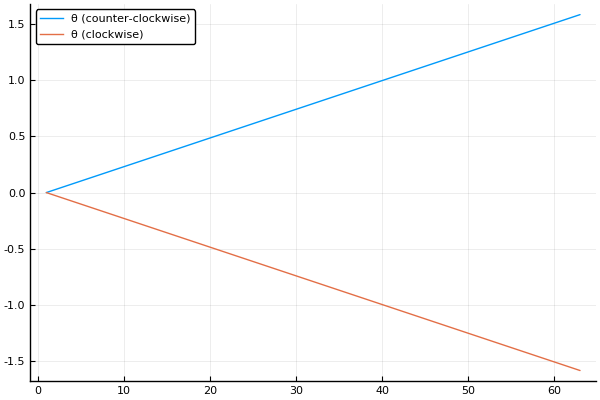

In [119]:
θr = map(p -> p.θ, poses_r)
θl = map(p -> p.θ, poses_l)

plot(θr, label="θ (counter-clockwise)")
plot!(θl, label="θ (clockwise)")

In [120]:
println("Expected 90° angle           : ", ϕ)
println("Actual 90° counter-clockwise : ", θr[end])
println("Actual 90° clockwise         : ", θl[end])

Expected 90° angle           : 1.5707963267948966
Actual 90° counter-clockwise : 1.5866141732283447
Actual 90° clockwise         : -1.5866141732283447


In [121]:
ϕerror = ϕ - θr[end]
ϕerror_ = ϕerror / ϕ

println("Error: ", round(ϕerror, digits=3), ", ", round(100 * ϕerror_, digits=2), "%")

Error: -0.016, -1.01%


**Compute Odometry Square 5m**

In [140]:
s = 5.0 # distance in meters
ϕ = 90π / 180 # 90° in rads
ω = 1.0 # rads per second

Δt = 50/1000 # 50 milliseconds

Tline = s / (ω * p3dx.R) # seconds to walk distance s
Nline = ceil(Int, Tline / Δt)

Tcorner = (ϕ * p3dx.L) / (ω * p3dx.R) # seconds to turn angle ϕ
Ncorner = ceil(Int, Tcorner / Δt)

N = 4 * Nline + 4 * Ncorner
x0 = y0 = θ0 = 0.0

poses = Vector{Pose}(undef, N+1)
poses[1] = Pose(x0, y0, θ0)
i = 1

for _=1:Nline
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, ω, Δt)
    i += 1
end

for _=1:Ncorner
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, -ω, Δt)
    i += 1
end

for _=1:Nline
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, ω, Δt)
    i += 1
end

for _=1:Ncorner
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, -ω, Δt)
    i += 1
end

for _=1:Nline
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, ω, Δt)
    i += 1
end

for _=1:Ncorner
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, -ω, Δt)
    i += 1
end

for _=1:Nline
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, ω, Δt)
    i += 1
end

for _=1:Ncorner
    poses[i+1] = compute_odometry(p3dx, poses[i], ω, -ω, Δt)
    i += 1
end

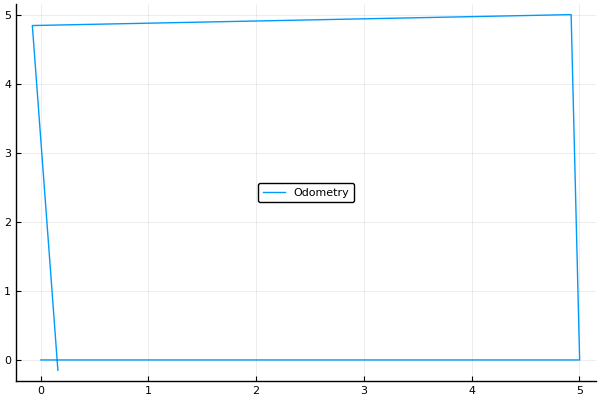

In [144]:
x = map(p -> p.x, poses)
y = map(p -> p.y, poses)

plot(x, y, label="Odometry")

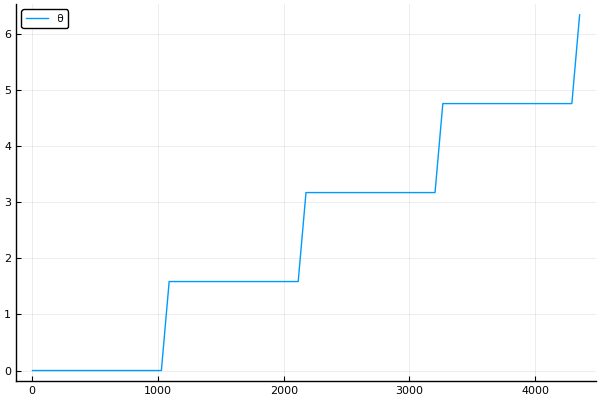

In [142]:
θ = map(p -> p.θ, poses)

plot(θ, label="θ")